# Spectral Virtual Diagnostic for **LPS** images from LCLS_HXR_05_16_2018_MD
@AdiHanuka - adiha@slac.stanford.edu

In [15]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from spec_utils import *
from sklearn import preprocessing
import time
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
import keras
from keras import optimizers
from keras.layers import Dense
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential, Model, Input
from keras import layers
plt.rcParams.update({'font.size': 16})

## Load data

In [19]:
X=np.load('lps_spectrum_60_binned.npy')
y=np.load('y_lpsdata.npy')

print('output - image',y.shape)
print('input',X.shape)

output - image (4046, 100, 100)
input (4046, 197)


In [3]:
# Reshape the 3d array into a 2d array for training
y_2D = np.zeros((y.shape[0],y.shape[1]*y.shape[2]))
for i in range(y.shape[0]):
    y_2D[i] = y[i].flatten()
y_2D.shape

(4046, 10000)

## Train NN 

In [4]:
def vd_trainer(X,y,batch_size = 2**6, epochs = 500, act='relu'):

#prepare data     
        yn = y / np.max(y) 
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        Xscale = scaler.fit_transform(X)
        x_train, x_test, y_train, y_test = train_test_split(Xscale, yn, test_size=0.2,random_state=69,shuffle=True)
    
#  build    
        inp = Input(shape = (x_train.shape[1],))
        x = layers.Dense(200, activation=act)(inp) 
        x = layers.Dense(100, activation=act)(x) 
        x = layers.Dense(50, activation=act)(x) 
        out = layers.Dense(y_train.shape[1], activation='linear')(x) # Output layer 
        model = Model(inputs=inp, outputs=out)
        model.compile(loss = 'mse', 
                      optimizer = 'adam',
                      metrics=['mae']) 
        print(model.summary())
            
#  fit
        start_time = time.time();
        history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=0,
                          validation_split = 0.1)
        print('Time to perform fit [mins] =  {0:.3f}' .format((time.time() - start_time)/60))
        plot_model_history(history)
        print('loss: ',history.history['loss'][-1])
        print('Validation loss: ',history.history['val_loss'][-1])
        
        score = model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])    
    
#predict using model on test points
        y_predict_test = model.predict(x_test) 
        y_predict_train = model.predict(x_train) 
        return y_test, y_predict_test

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               39600     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 10000)             510000    
Total params: 574,750
Trainable params: 574,750
Non-trainable params: 0
_________________________________________________________________
None

Time to perform fit [mins] =  2.

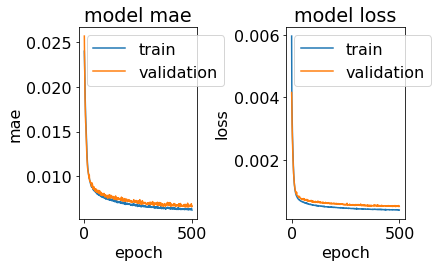

loss:  0.0003827563755644056
Validation loss:  0.0005010987386210925
Test loss: 1.3633336106494909
Test accuracy: 0.02402891032397747


In [5]:
y_test, y_predict = vd_trainer(X,y_2D,epochs = 500)

# Plot stuff

In [6]:
def plot_lps_vs_prediction(lps,predicted_lps,idx=None):
        dt = 3.1531; # Time resolution From Alberto's TCAV axis conversion [fs/pixel]
        dE = -0.88842;# Energy resolution [MeV/pix]
        dx = (np.arange(y.shape[1])-np.round(y.shape[1]/2))*dt;
        dy = (np.arange(y.shape[2])-np.round(y.shape[2]/2))*dE;
        
        predicted_lps = predicted_lps.reshape(predicted_lps.shape[0],lps.shape[1],lps.shape[2]) #3D       
        if idx is not None:
            ns = idx     
        else:
            ns = np.random.choice(lps.shape[0]);          
        fig, (ax, ax2,ax3) = plt.subplots(1,3,figsize=(10,4))
        z1 = ax.imshow(lps[ns],extent=(dx[0],dx[dx.shape[0]-1],dy[0],dy[dy.shape[0]-1]),interpolation = 'none')
        ax.set_aspect(4)
        ax.set_xlabel('Time [fs]')
        ax.set_ylabel('Energy Deviation [MeV]')
        ax.set_title('shot: '+ str(ns))
#         plt.colorbar(z1,ax=ax) 
        z2 = ax2.imshow(predicted_lps[ns],extent=(dx[0],dx[dx.shape[0]-1],dy[0],dy[dy.shape[0]-1]),interpolation = 'none')
        ax2.set_xlabel('Time [fs]')
        ax2.set_aspect(4)
        ax2.set_title('predicted')
#         plt.colorbar(z2,ax=ax2)
        z3 = ax3.imshow(np.abs(predicted_lps[ns]-lps[ns]),extent=(dx[0],dx[dx.shape[0]-1],dy[0],dy[dy.shape[0]-1]),interpolation = 'none')
        ax3.set_xlabel('Time [fs]')
        ax3.set_aspect(4)        
        ax3.set_title('diff')
         
        plt.tight_layout()
        plt.show()

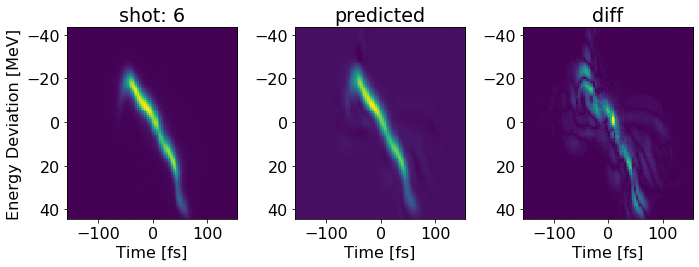

In [7]:
#model prediction
ix=6
plot_lps_vs_prediction(y_test.reshape(y_test.shape[0],y.shape[1],y.shape[2]),y_predict, ix)  

In [13]:
# #save
# np.save('Models/y_pred_spec_2D.npy',y_predict)
# np.save('Models/y_test_2D.npy',y_test)

## Metrics 

In [10]:
#ssim
import skimage
from skimage.metrics import structural_similarity as ssim

ssim(y_test, y_predict)

/usr/common/software/tensorflow/gpu-tensorflow/1.15.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


0.9690442150750922

In [11]:
#find most uncertain examples in spectrum input
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score 

mse = np.array([mean_squared_error(y_test[i,:],y_predict[i,:])/mean_squared_error(y_test[i,:],0*y_test[i,:]) for i in range(y_predict.shape[0])])
mse_ix = (np.array(mse)).argsort()[::-1]
print('mse',mse.mean())
cond=mse<1
mse=mse[cond]
print('mse',mse.mean())

print('mse top 10 index',mse_ix[:12])

mse 2353043.7197986236
mse 0.053667663480497584
mse top 10 index [751 196 406 731 738 226  46 391 311  21 669 468]


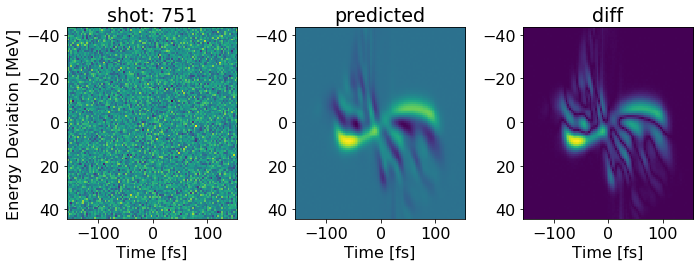

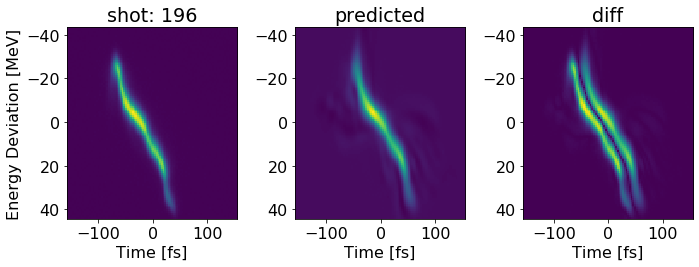

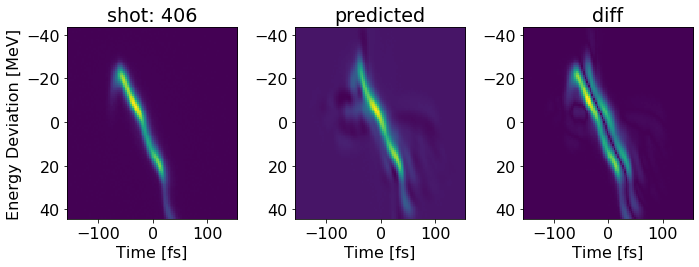

In [12]:
for i in range(3):
    plot_lps_vs_prediction(y_test.reshape(y_test.shape[0],y.shape[1],y.shape[2]),y_predict, mse_ix[i])  